In [2]:
using Random, LinearAlgebra, Plots

In [3]:
using Combinatorics

In [4]:
using Permutations

In [5]:
function A_matrix_calc(a_vecs,indices)
    N = length(indices)
    A = zeros(N,N)
    for j in 1:N
        for k in 1:N
            A[j,k]=a_vecs[j,indices[k]]
        end
    end
    return A
end;

In [6]:
function generate_binary_vectors(N)
    # Check if N is even
    permutations_arr = fill(zeros(Int, N), binomial(N,N÷2))

    @assert N % 2 == 0
    
    # Generate all combinations of N/2 ones
    for (i,combo) in enumerate(combinations(1:N, N ÷ 2))
        # Create a binary vector with all zeros
        vector = zeros(Int, N)
        
        # Set the positions in the combination to 1
        for pos in combo
            vector[pos] = 1
        end
        
        # Print or process the binary vector
        permutations_arr[i]=vector
    end
    return permutations_arr
end;

In [7]:
# Define the tight binding Hamiltonian
function tight_binding_hamiltonian_single_spin(N, t=1)
    diag = -t * ones(N-1)
    H_sp = diagm(1=>diag, -1=>diag)
    H_sp[1,N] = -t  #for PBC
    H_sp[N,1] = -t  #for PBC
    return H_sp
end;

In [8]:
function find_indices(binary_vector)
    # Find indices of ones
    indices_ones = findall(x -> x == 1, binary_vector)
    
    # Find indices of zeros
    indices_zeros = findall(x -> x == 0, binary_vector)
    
    return indices_ones, indices_zeros
end;

In [9]:
function calc_gutz_coef(config,eigenvectors)
    indices_ones,indices_zeros=find_indices(config)
    @assert length(indices_ones) == length(indices_zeros)
    indices_permutations = [indices_zeros;indices_ones]
    p = Permutation(indices_permutations)
    sign_p = sign(p)
    A1 = A_matrix_calc(eigenvectors'[1:end÷2,:],indices_ones)
    A0 = A_matrix_calc(eigenvectors'[1:end÷2,:],indices_zeros)
    return sign_p*det(A0)*det(A1)
end;

In [10]:
function swap_particles_in_bond_i(configuration,i)
    N= length(configuration)
    config_copy=copy(configuration)
    config_copy[i]=configuration[i%N+1]
    config_copy[i%N+1]=configuration[i]
    return config_copy
end;

In [11]:
function possible_variations(config)
    N=length(config)
    opposite_spins_bonds_indices = []
    for i in 1:N
        if config[i] != config[i%N+1]
            append!(opposite_spins_bonds_indices,i)
        end
    end
    
    variations = Vector{Vector{Int}}()
    for (i, bond) in enumerate(opposite_spins_bonds_indices)
        variation = swap_particles_in_bond_i(config,bond)
        push!(variations, variation)
    end
    return variations
    
end;

In [12]:
function generate_binary_vector(N)
    # Create a vector with N/2 ones and N/2 zeros
    vector = [ones(Int, div(N, 2)); zeros(Int, div(N, 2))]
    # Shuffle the vector to randomize the order of ones and zeros
    shuffle!(vector)
    return vector
end;

In [13]:
function VMC_Hheisenberg_with_gutzwiller_projection_of_half_filled_fermi_sea_ansatz(N,steps)
    # ED the tight binding hamiltonian to find a_i coefficients
    H=tight_binding_hamiltonian_single_spin(N)
    eigenvalues, eigenvectors = eigen(H);
    
    α = generate_binary_vector(N)
    sum=0
    
    for i in 1:steps
        local_min_flag = true
        α_gutz_coef = calc_gutz_coef(α,eigenvectors)
        possible_variations_of_α = possible_variations(α)

        temp_sum= 0
        # count the trivial contributions from β=α
        temp_sum += (N-length(possible_variations_of_α))/4
        #
        for β in possible_variations_of_α
            β_gutz_coef = calc_gutz_coef(β,eigenvectors)
            addition_to_sum = 0.5*β_gutz_coef/α_gutz_coef
            temp_sum += addition_to_sum
        end
        for α′ in possible_variations_of_α
            α′_gutz_coef = calc_gutz_coef(α′,eigenvectors)
            ratio= (α′_gutz_coef^2)/(α_gutz_coef^2)
            if rand() <= ratio
                #accept change
                α=α′
                local_min_flag = false
                break
            end
            sum += temp_sum
        end
        if local_min_flag
            println("got to local min")
        end
        
    end
    return sum/steps
end;

In [19]:
function mean(arr)
    return sum(arr)/length(arr)
end;

In [66]:
function run_MC_simulations(N,number_of_simulations,iterations)
    res_arr=[]
    for i in 1:number_of_simulations
        res=VMC_Hheisenberg_with_gutzwiller_projection_of_half_filled_fermi_sea_ansatz(N,iterations)
        append!(res_arr,res/N)
    end
    return res_arr
end;

In [125]:
number_of_simulations = 100
N = 100
iterations = 1000
@time res_arr = run_MC_simulations(N,number_of_simulations,iterations)
mean_res = mean(res_arr)

387.405096 seconds (156.51 M allocations: 868.184 GiB, 2.44% gc time)


-0.3519170609203394

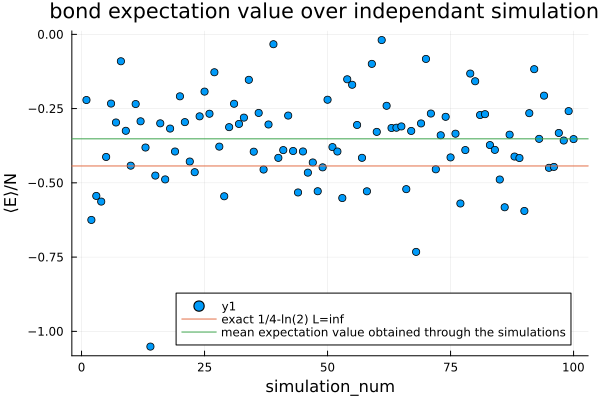

In [126]:
plot()
scatter!(1:number_of_simulations,res_arr,title="bond expectation value over independant simulations",xlabel="simulation_num",ylabel="⟨E⟩/N")
hline!([1/4-log(2)],label="exact 1/4-ln(2) L=inf")
hline!([mean_res],label="mean expectation value obtained through the simulations")